In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Similarly, we also built a language model using the input of a list of French female names. We adjusted the parameters to make sure they fit the character size of French language, and we got a model with similar quality to the Spanish model.

https://vocab.chat/blog/french-female-names.html#list-of-names

In [4]:
file_path = '/content/drive/MyDrive/ASS 2/French.csv'

words = open(file_path, 'r').read().lower(). splitlines()
words[:8]

['marie',
 'nathalie',
 'sylvie',
 'isabelle',
 'stéphanie',
 'martine',
 'valérie',
 'sandrine']

In [5]:
len(words)

501

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'ç', 29: 'è', 30: 'é', 31: 'ë', 32: 'ï', 0: '.'}


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([3453, 3]) torch.Size([3453])
torch.Size([415, 3]) torch.Size([415])
torch.Size([417, 3]) torch.Size([417])


In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((33, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 33), generator=g)
b2 = torch.randn(33, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

13163

In [10]:
for p in parameters:
  p.requires_grad = True

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [12]:
lri = []
lossi = []
stepi = []

In [13]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    #print(loss.item())

In [1]:
plt.plot(stepi, lossi)

NameError: name 'plt' is not defined

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.8783, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.9025, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(5.5595, grad_fn=<NllLossBackward0>)

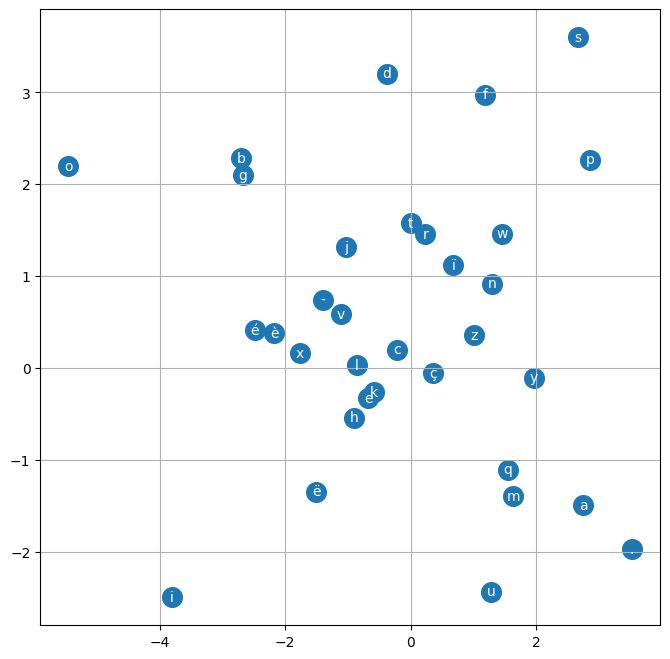

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

lou-anne-marie.
lucette.
eléonorine.
carie-pierrette.
marinne-gaetancette.
madeleine.
julie.
rosalie.
ghislaine.
christine.
abine.
typhaëlle.
frane.
dorine.
roxane.
clementine.
carie-thérèse.
maëlle.
jocelyne.
loetitia.


In [ ]:
correct = 0
total = 0

# Evaluate on the validation set
for i in range(Xdev.shape[0]):
    emb = C[Xdev[i]]  # (block_size, embedding_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (1, hidden_dim)
    logits = h @ W2 + b2  # (1, num_classes)
    prediction = torch.argmax(logits, dim=1).item()
    if prediction == Ydev[i].item():
        correct += 1
    total += 1

accuracy = correct / total
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.4843373493975904
